In [1]:
import numpy as np
import pandas as pd

from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

import torch 
import torch.nn as nn
import torch.nn.functional as F

from astropy.io import fits



#device=torch.device(0 if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


In [ ]:
from basic_code.loading import loading
from basic_code.CNN_result import CNN_result
from basic_code.sampling import sampling
from basic_code.hist_plot import hist_plot
from basic_code.scatter_plot import scatter_plot
N_FIGS = 9

model_name = 'Mastar'
model, Data = loading(model_name, device, no_z = False) # 0-4: 5band pho; 5: redshift; 6: VT centers; 7: Mask; 8: Reference Mass
test_set = Data[int(0.8*len(Data)):,:,:,:]
where_ctr = test_set[:,(N_FIGS-3):(N_FIGS-2),:,:].bool().reshape([len(test_set),10000]).to('cpu')

cuda:0


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm
import cv2
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

import torch 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from astropy.io import fits
from matplotlib import pyplot as plt

def Conv2D(in_channels,out_channels,kernel_size,padding):
    conv = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride=1, padding = padding),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2)
        )
    return conv

class CNN_noVT(nn.Module):
    mass_std = 2.0667
    mass_mean = 3.5082

    photo_std = 0.8338
    photo_mean = 1.4620
    
    def __init__(self, in_chan=5 , mid=64 , out = 1,
                kernel_size = 5,
                n_layers  =3):
        padding = int(kernel_size/2)
        super(CNN_noVT, self).__init__()
        self.redshift = Conv2D(6,6,1,0)
        self.conv_1 =Conv2D(in_chan-1,mid,kernel_size,padding = padding)
        conv = []
        #self.norm = nn.BatchNorm2d(3)
        for i in range(0,n_layers-1):
            conv.append(
                nn.Conv2d(in_channels = mid, out_channels = mid, kernel_size = kernel_size, stride=1, padding = padding),
            )
            conv.append(nn.ReLU())
            #conv.append(nn.BatchNorm2d(mid))
        self.conv = nn.Sequential(*conv)
        self.conv_f1 =Conv2D(mid,int(mid/2),kernel_size,padding = padding)
        self.conv_f2 =Conv2D(int(mid/2),out,kernel_size,padding = padding)
        #self.conv_f3 =Conv2D(out,out,1,padding = 0)
    def forward(self, x):
        #img = torch.clone(x[:,:6,:,:])
        #img[:,5,:,:]*=100
        img = torch.cat([x[:,:4,:,:],x[:,5:6,:,:]],dim = 1)
        img[:,-1,:,:]*=100
        VT = torch.clone(x[:,7:,:,:])
        #img = self.redshift(img)#*0.1+img[:,:5,:,:]
        
        x_ = torch.cat([img,VT],dim=1).clone()
        x_ = self.conv_1(x_)
        x_ = self.conv(x_)
        x_ = self.conv_f1(x_)
        x_ = self.conv_f2(x_)#-np.log10(0.25)
        #x_ = 0.1*self.conv_f3(x_)+x_
        #x_ = x_*filter
        return x_, torch.log10(torch.sum(10**x_))  

In [10]:
model = torch.load('./models/Mastar_no_z/Mastar_no_z_90.pt',map_location=device)

In [3]:
s_n = torch.load('./catalog/s_n.pt')
sn_test = s_n[int(0.8*len(s_n)):]

for i in range(0,int(len(test_set))):
    img_sn  = sn_test[i,:,:,1]
    
    sn_1d = torch.tensor(img_sn.ravel())
    if not i:
        ts_sn = sn_1d[where_ctr[i]]
    else:
        ts_sn = torch.cat([ts_sn,sn_1d[where_ctr[i]]])
        
#ts_sn = ts_sn.numpy()
print(i)

1652


(574511,)
torch.Size([569034])


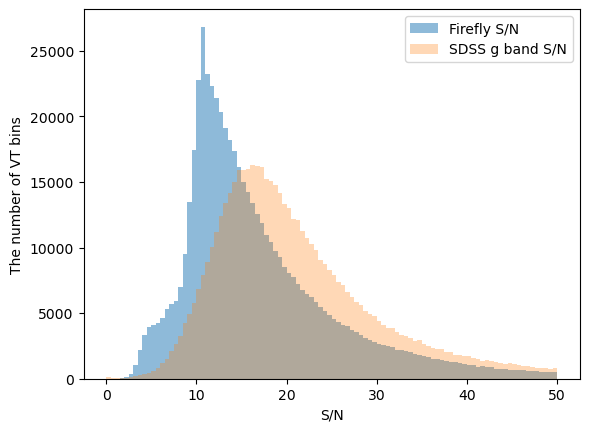

In [4]:
hdulInfo = fits.open('./manga-firefly-v3_1_1-mastar.fits')
id_list = np.loadtxt('./catalog/dr17_mastarid.txt', dtype = int)
test_id = id_list[int(0.8*len(Data)):]
ff_sn = hdulInfo[15].data[test_id]
ff_sn = ff_sn[ff_sn>0]
print(ff_sn.shape)
print(ts_sn.shape)

plt.hist(ff_sn, range = [0,50], bins = 100, label = 'Firefly S/N', alpha = 0.5)
plt.hist(ts_sn, range = [0,50], bins = 100, label = 'SDSS g band S/N', alpha = 0.3)
plt.xlabel('S/N')
plt.ylabel('The number of VT bins')
plt.legend()
plt.savefig('./Analyses/SDSS_FF_sn.pdf')
plt.show()

In [18]:
print(test_id)

[5696. 4457.  132. ... 5914. 8486. 8044.]


In [18]:
# Masking by g-band photometry S/N
threshold = 20
g_mask = s_n[:,:,:,1]<threshold
g_mask = g_mask.astype(int)

Data_gmask = torch.ones(Data.shape)
for i in range(0,9):
    Data_gmask[:,i,:,:] = Data[:,i,:,:].to('cpu')*g_mask

In [3]:
stats = sampling(model, Data.to(device))
all_truth, all_pred, all_bell, gmass, VT_diff = stats

NameError: name 'test_set' is not defined

In [2]:
hist_plot(stats, mode  = 'galaxy', name = model_name+'_below_20')
hist_plot(stats, mode  = 'VT', name = model_name+'_below_20')
scatter_plot(stats, name = model_name+'_below_20')

NameError: name 'hist_plot' is not defined

In [21]:
all_truth, all_pred, gmass, VT_diff = stats
print(len(ts_sn))
print(len(all_truth))

569034
569034


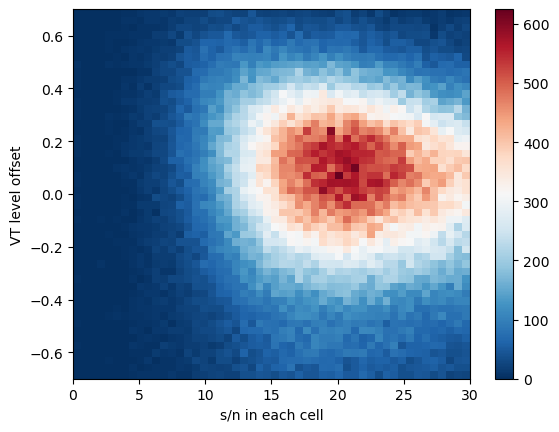

In [17]:
plt.hist2d(ts_sn.numpy(),(all_truth-all_pred).numpy(), range = [[0,30],[-0.7,0.7]], bins = 50, cmap = 'RdBu_r')
plt.colorbar()
#plt.xlim(-2,2)
plt.ylim(-0.7,0.7)
plt.ylabel('VT level offset')
plt.xlabel('s/n in each cell')
plt.show()

Standard deviations for each bin: [0.50061834 0.58716928 0.67005674 0.67692005 0.56698273 0.55486351
 0.50589432 0.4689388  0.46896341 0.44009232 0.4187112  0.40447052
 0.40266474 0.39799786 0.37079296 0.36849844 0.35738211 0.35685554
 0.35223162 0.34225736 0.33735922 0.33120208 0.33908383 0.33499062
 0.33962552 0.3344564  0.33369889 0.32507075 0.33009838 0.33901984]
Means for each bin: [ 0.0163679  -0.3143468  -0.09295934 -0.08733506 -0.02438553 -0.04454431
 -0.00301739  0.04853525  0.05221247  0.04865676  0.04870348  0.03008475
  0.02436532  0.01562091  0.01490611  0.00858583  0.00926432  0.00413551
  0.00400953  0.00577731  0.00467202  0.00221586 -0.00664111 -0.0077493
 -0.00740904 -0.0152507  -0.02061342 -0.02806527 -0.02081401 -0.0273617 ]


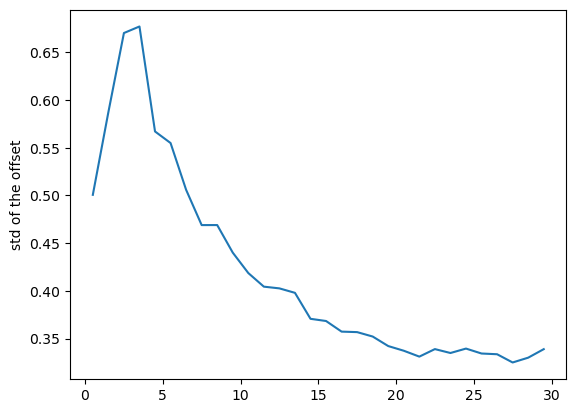

In [18]:
# 将 a[0, :] 按 0 到 2 的区间分成 10 个 bin
bins = np.linspace(0, 30, 31)
bin_indices = np.digitize(ts_sn, bins) - 1  # 获取每个值所属的 bin 的索引

# 初始化存储每个 bin 中 a[1, :] 的 std 和 mean 的数组
std_values = np.zeros(30)
mean_values = np.zeros(30)

# 计算每个 bin 中 a[1, :] 的 std 和 mean
for i in range(30):
    # 获取当前 bin 中的所有值
    bin_mask = (bin_indices == i)
    bin_values = (all_truth-all_pred)[bin_mask].numpy()
    
    if len(bin_values) > 0:  # 确保 bin 中有值
        std_values[i] = np.std(bin_values)
        mean_values[i] = np.mean(bin_values)
    else:
        std_values[i] = np.nan
        mean_values[i] = np.nan

print("Standard deviations for each bin:", std_values)
print("Means for each bin:", mean_values)

plt.plot((bins[:-1]+bins[1:])/2, std_values)
plt.ylabel('std of the offset')
plt.xlabel('')
plt.show()

7.47733580109676
tensor(9.4310, dtype=torch.float64) tensor(8.9581, dtype=torch.float64)


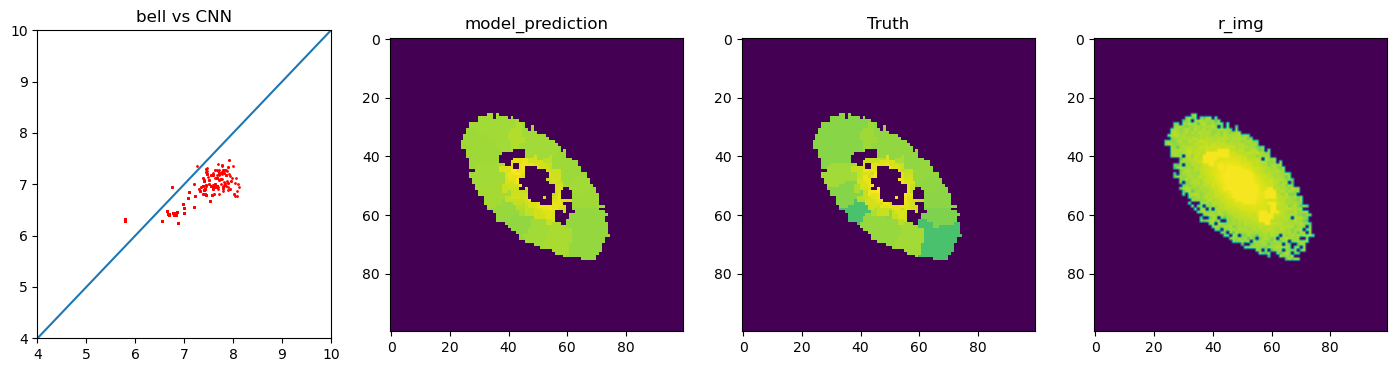

7.888922675463389
tensor(9.7752, dtype=torch.float64) tensor(9.2637, dtype=torch.float64)


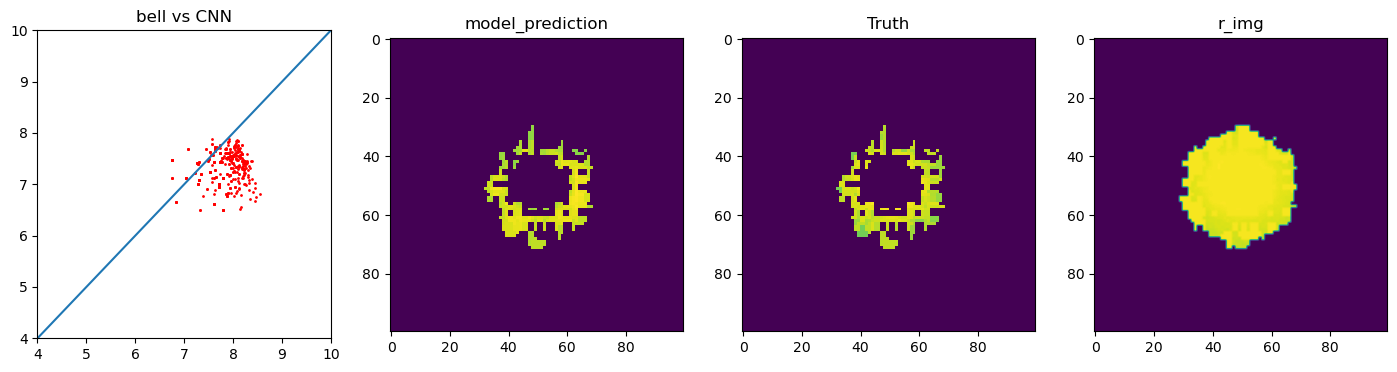

8.268042861113408
tensor(10.1081, dtype=torch.float64) tensor(9.4982, dtype=torch.float64)


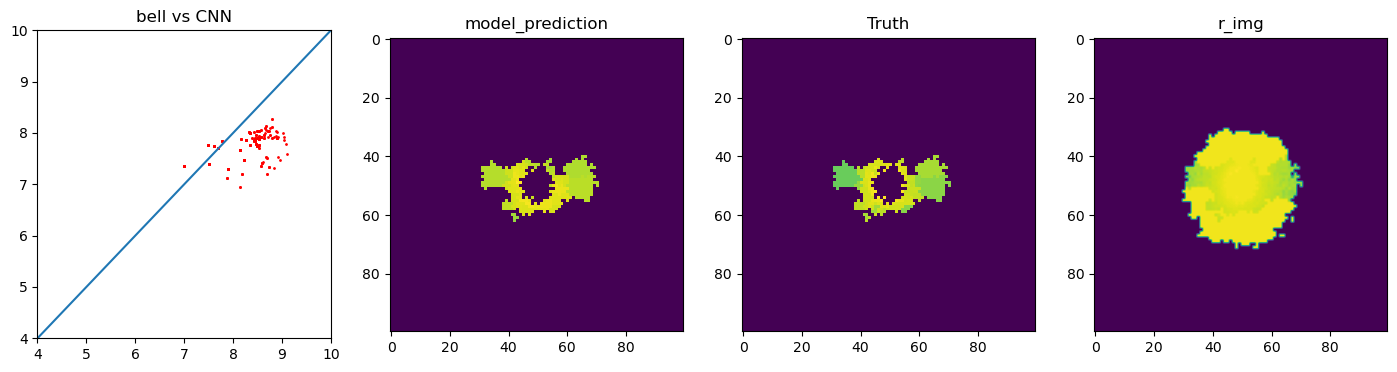

8.161760403157857
tensor(10.1597, dtype=torch.float64) tensor(9.5867, dtype=torch.float64)


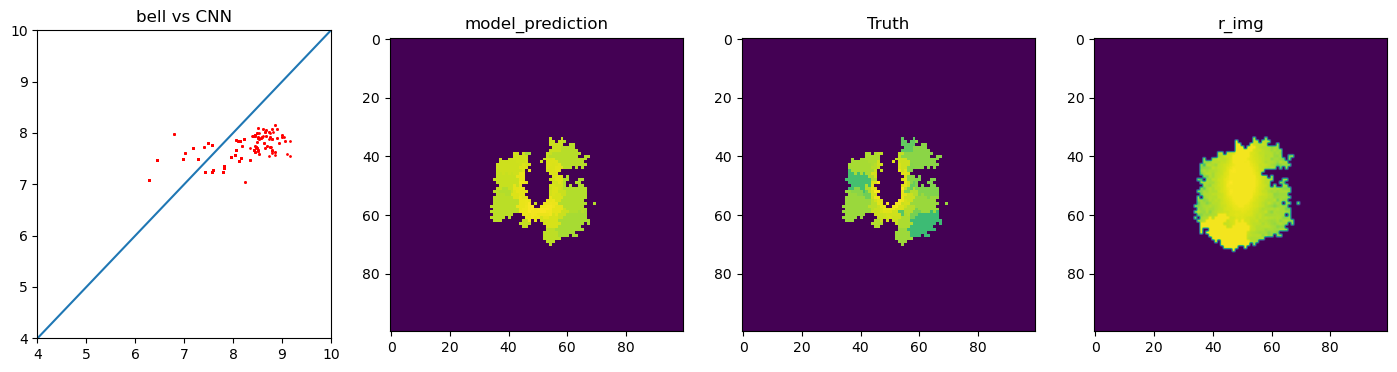

8.240640650164282
tensor(9.5896, dtype=torch.float64) tensor(9.5432, dtype=torch.float64)


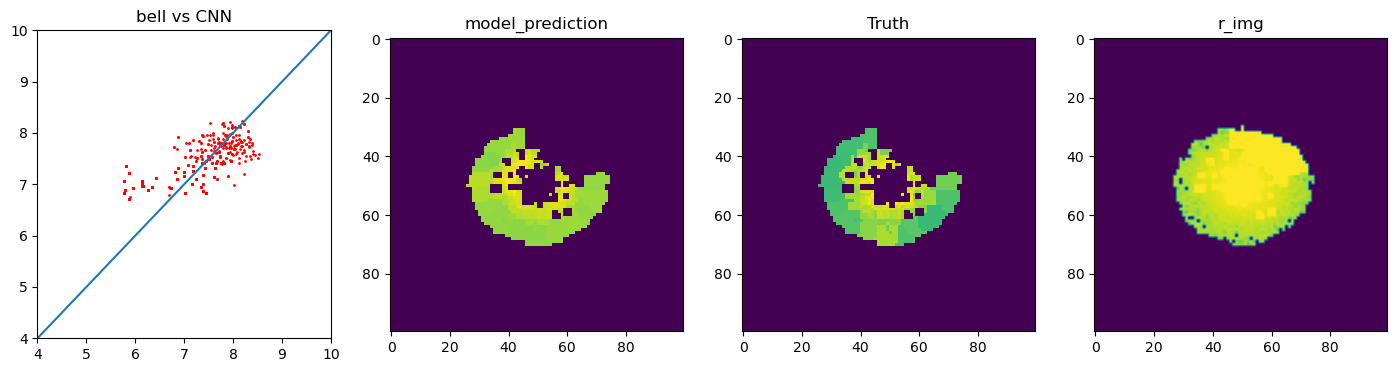

7.781247189789041
tensor(9.5777, dtype=torch.float64) tensor(9.3343, dtype=torch.float64)


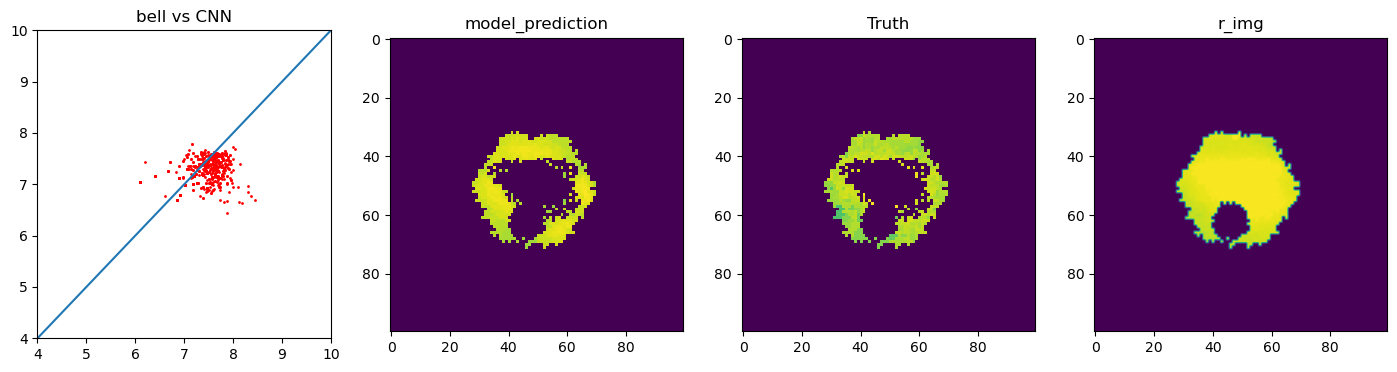

9.674971824164006
tensor(11.0477, dtype=torch.float64) tensor(10.8174, dtype=torch.float64)


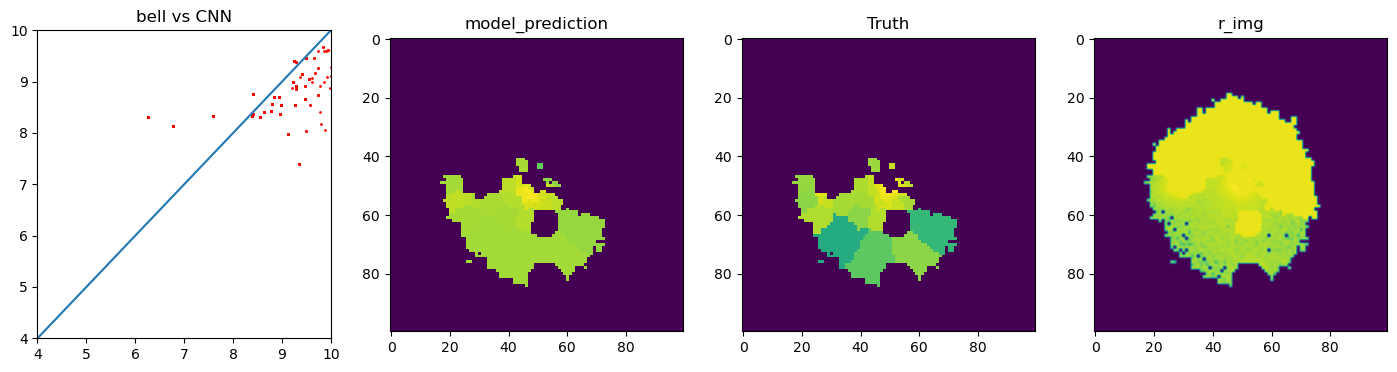

7.45385121651628
tensor(9.1085, dtype=torch.float64) tensor(9.0276, dtype=torch.float64)


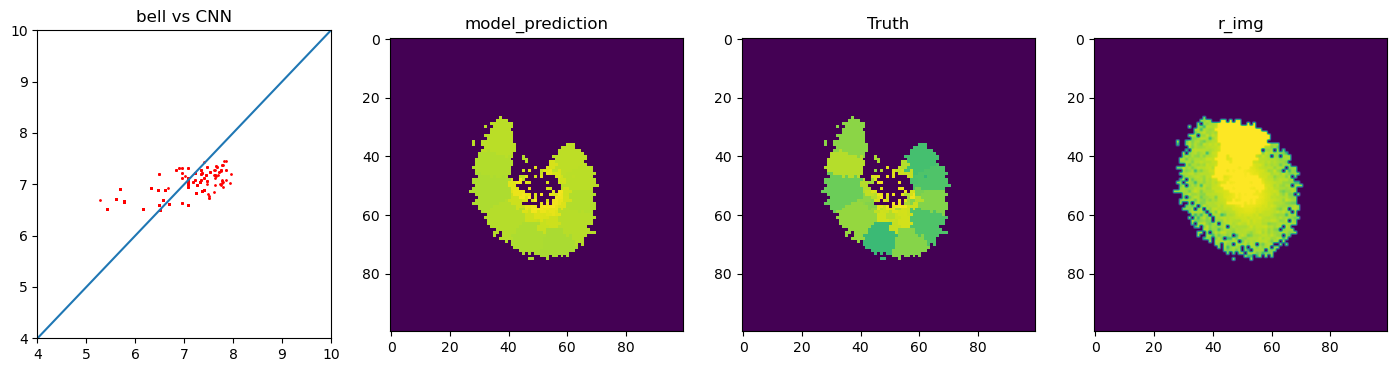

8.602684960230782
tensor(10.2340, dtype=torch.float64) tensor(9.3328, dtype=torch.float64)


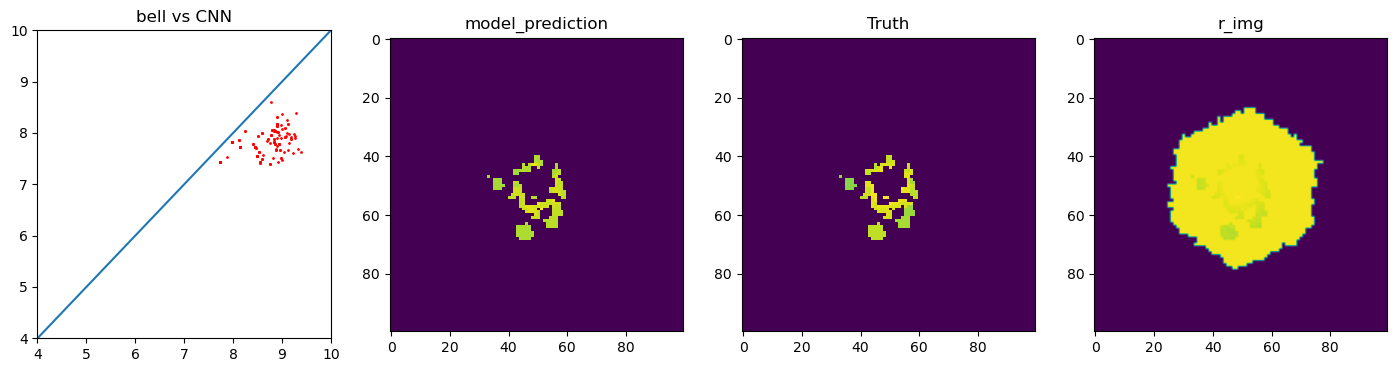

7.695082677835995
tensor(9.6448, dtype=torch.float64) tensor(9.2535, dtype=torch.float64)


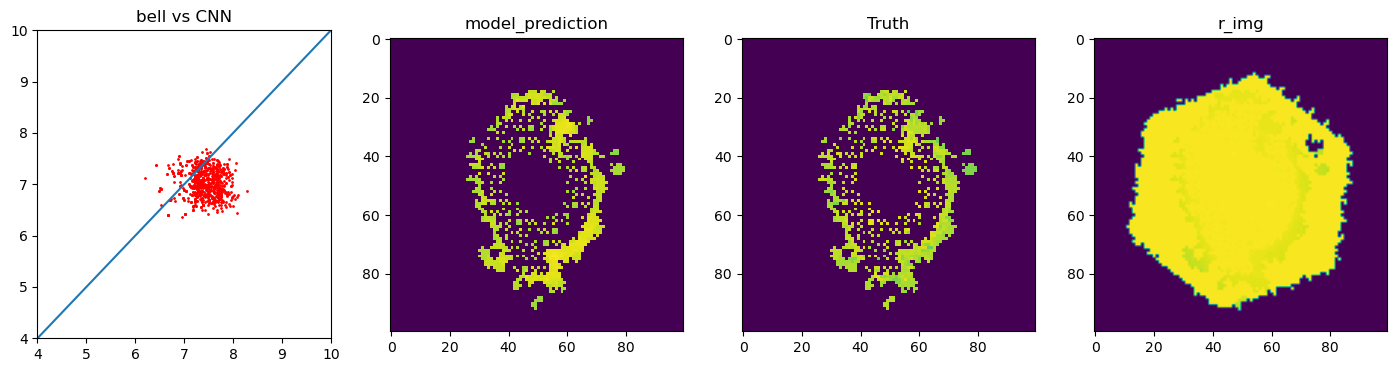

In [21]:
from basic_code.CNN_result import M_L
mode = 'test'
#where_ctr = test_set[:,(N_FIGS-3):(N_FIGS-2),:,:].bool().reshape([len(test_set),10000]).to('cpu')
for i in range(10,20):
    result = CNN_result(model,i, Data_gmask, mode)
    #result.Gaussian(k_size=33, sigma = 15)
    
    r_img = result.x[0,2,:,:].to('cpu').detach().numpy()
    M_L_r = M_L(result.x[0,(1,2),:,:].to('cpu').detach().numpy(), -0.306, 1.097)
    #bell_mass = result.VT_bined(M_L_r+r_img+9)
    
    

    mass_pred = result.get_img('pred')
    mass_pred_VT, mass_tru, manga_id = result.VT_lize()
    print(mass_pred_VT.max())
    print(torch.log10(result.total_mass()[1]),torch.log10(result.total_mass()[0]))

    
    #result_ = CNN_result(model,i, mode,data = Data_firefly)
    #mass_firefly = result_.VT_lize()[1]
    
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,4))
    
    x = np.linspace(4,10,10)
    #axes[0].scatter(mass_tru.ravel(),mass_pred_VT.ravel(),s=1,color = 'red')
    axes[0].scatter(mass_tru.ravel(),mass_pred_VT.ravel(),s=1,color = 'red')
    #axes[0].scatter(mass_tru.ravel(),bell_mass.ravel(), s=1,color = 'blue')
    axes[0].plot(x,x)
    axes[0].set_xlim(4,10)
    axes[0].set_ylim(4,10)
    axes[0].title.set_text('bell vs CNN')
    

    
    #plt.subplot(132)
    axes[1].imshow(mass_pred_VT,interpolation='none')
    axes[1].title.set_text('model_prediction')
    
    #plt.subplot(133)
    axes[2].imshow(mass_tru,interpolation='none')
    axes[2].title.set_text('Truth')
    
    
    #r_img = Data[int(len(Data)*0.8)+i,2,:,:].to('cpu').detach().numpy()
    axes[3].imshow(r_img)
    axes[3].title.set_text('r_img')
    #plt.savefig('./new_image/dr12_good_'+str(manga_id)+'.png')
    fig.subplots_adjust(right=0.8)
    plt.show()